
Practica 3 (Pendulum-v1 versión Q-Learning)

Aldana Smyna Medina Lostaunau

Claudia Vidal Otero

IMPORTACIONES

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import os
import time

CONFIGURACIÓN DE HIPERPARÁMETROS

In [14]:
ENV_NAME = 'Pendulum-v1'
RENDER = False
PERTURBACIONES = False
PERTURB_PROB = 0.05 #Pedida por el enunciado
PERTURB_VALS = [-2.0, 2.0]  #Pedidos por el enunciado

N_ANGLE_BINS = 30 
N_VELOCITY_BINS = 15 
N_ACTIONS = 11


ANGLE_MIN, ANGLE_MAX = -np.pi, np.pi
VEL_MIN, VEL_MAX = -8.0, 8.0
ACTION_MIN, ACTION_MAX = -2.0, 2.0

NUM_EPISODES = 20000
MAX_STEPS = 200
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_DECAY = 0.995
EPSILON_END = 0.01
ALPHA = 0.1


angle_bins = np.linspace(ANGLE_MIN, ANGLE_MAX, N_ANGLE_BINS + 1)
vel_bins = np.linspace(VEL_MIN, VEL_MAX, N_VELOCITY_BINS + 1)
action_list = np.linspace(ACTION_MIN, ACTION_MAX, N_ACTIONS)



FUNCIONES AUXILIARES


In [15]:

# Discretiza el estado continuo (observación) en índices para la tabla Q
def discretize_state(obs):
    cos_theta, sin_theta, theta_dot = obs  # Extrae componentes de la observación
    theta = np.arctan2(sin_theta, cos_theta)  # Calcula el ángulo a partir del seno y coseno
    angle_idx = np.digitize(theta, angle_bins) - 1  # Asigna el ángulo a un intervalo discreto
    vel_idx = np.digitize(theta_dot, vel_bins) - 1  # Discretiza la velocidad angular
    angle_idx = np.clip(angle_idx, 0, N_ANGLE_BINS - 1)  # Asegura que el índice esté en rango válido
    vel_idx = np.clip(vel_idx, 0, N_VELOCITY_BINS - 1)
    return (angle_idx, vel_idx)  # Devuelve la tupla de estado discreto

# Política epsilon-greedy: elige una acción aleatoria con probabilidad epsilon, si no elige la mejor
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(N_ACTIONS)  # Exploración
    else:
        return np.argmax(Q[state])  # Explotación: acción con mayor valor Q

# Aplica una posible perturbación aleatoria a la acción elegida
def apply_perturbation(action):
    if np.random.rand() < PERTURB_PROB:
        return [np.random.choice(PERTURB_VALS)] 
    else:
        return [action]  


ALGORITMO DE Q-LEARNING

In [16]:
def q_learning(env):
    Q = defaultdict(lambda: np.zeros(N_ACTIONS))  # Inicializa tabla Q con ceros 
    returns = []  # Almacena el retorno total por episodio
    epsilon = EPSILON_START  

    for ep in range(1, NUM_EPISODES + 1):  
        obs, _ = env.reset()  # Reinicia el entorno
        state = discretize_state(obs)  # Discretiza la observación inicial
        total_reward = 0  

        for t in range(MAX_STEPS):  
            action_idx = epsilon_greedy(Q, state, epsilon)  # Selecciona una acción con política epsilon-greedy
            action = action_list[action_idx]  # Traduce índice de acción a valor real (continuo/discreto)

            if PERTURBACIONES:  # Si hay perturbaciones
                action = apply_perturbation(action)[0]

            # Ejecuta la acción en el entorno
            next_obs, reward, terminated, truncated, _ = env.step([action])
            next_state = discretize_state(next_obs)
            done = terminated or truncated  

            # Q-learning update
            best_next_action = np.argmax(Q[next_state])  # Acción con mayor valor en el siguiente estado
            td_target = reward + GAMMA * Q[next_state][best_next_action]  # Cálculo del valor objetivo
            td_error = td_target - Q[state][action_idx]  # Error
            Q[state][action_idx] += ALPHA * td_error  # Actualiza la tabla Q

            total_reward += reward
            state = next_state  # Pasa al siguiente estado

            if done:
                break  

        returns.append(total_reward)  # Guarda el retorno del episodio
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)  

        
        if ep % 500 == 0:
            print(f"Episodio {ep}/{NUM_EPISODES}, retorno medio últimos 500: {np.mean(returns[-500:]):.2f}")

    return Q, returns  # Devuelve la tabla Q aprendida y los retornos por episodio



EVALUACIÓN DE POLÍTICA

In [17]:
def evaluar_politica(policy_det, n_episodios=1000):
    # Crea un entorno nuevo para evaluación. Modo 'human' si RENDER está activo, para visualizar
    env_eval = gym.make(ENV_NAME, render_mode='human' if RENDER else None)
    retornos = []  

    for _ in range(n_episodios):
        obs, _ = env_eval.reset()  # Reinicia el entorno
        state = discretize_state(obs)  # Convierte la observación inicial al estado discreto
        total_reward = 0 

        for _ in range(MAX_STEPS):
            # Obtiene la acción de la política aprendida (determinista), o aleatoria si no está en la política
            action_idx = policy_det.get(state, np.random.choice(N_ACTIONS))
            action = action_list[action_idx]  # Traduce el índice a acción real

            # Ejecuta la acción en el entorno
            obs, reward, terminated, truncated, _ = env_eval.step([action])
            total_reward += reward
            state = discretize_state(obs)  # Actualiza el estado

            if terminated or truncated:  
                break

        retornos.append(total_reward)  # Guarda la recompensa total del episodio

    env_eval.close()  # Cierra el entorno
    return np.mean(retornos), np.std(retornos)  # Devuelve media y desviación estándar del desempeño


VISUALIZACIÓN DE POLÍTICA

In [21]:
def visualizar_politica(policy_det, n_episodios=5):
    env_vis = gym.make(ENV_NAME, render_mode='human')  # Crea el entorno con visualización activada

    for ep in range(n_episodios):
        obs, _ = env_vis.reset()  # Reinicia el entorno
        state = discretize_state(obs)  # Convierte la observación en estado discreto
        total_reward = 0  
        print(f"\n[EPISODIO {ep+1}]")  # Muestra inicio del episodio

        for t in range(MAX_STEPS):
            # Obtiene la acción de la política aprendida o elige aleatoria si el estado no existe
            action_idx = policy_det.get(state, np.random.choice(N_ACTIONS))
            action = action_list[action_idx]  # Traduce a acción real

            # Ejecuta la acción y recibe nueva observación y recompensa
            obs, reward, terminated, truncated, _ = env_vis.step([action])
            total_reward += reward
            state = discretize_state(obs)  # Actualiza el estado

            env_vis.render()  # Muestra visualmente

            if terminated or truncated:
                break  

        print(f"Retorno del episodio {ep+1}: {total_reward:.2f}")  # Muestra el retorno final del episodio
        time.sleep(1)
        
    env_vis.close()  # Cierra el entorno


EJECUCIÓN ALGORITMO

In [22]:

env = gym.make(ENV_NAME, render_mode=None)
Q, returns = q_learning(env)

policy_det = {s: np.argmax(a) for s, a in Q.items()}

os.makedirs('resultados', exist_ok=True)


Episodio 500/20000, retorno medio últimos 500: -1204.00
Episodio 1000/20000, retorno medio últimos 500: -1133.63
Episodio 1500/20000, retorno medio últimos 500: -881.92
Episodio 2000/20000, retorno medio últimos 500: -758.70
Episodio 2500/20000, retorno medio últimos 500: -679.97
Episodio 3000/20000, retorno medio últimos 500: -528.56
Episodio 3500/20000, retorno medio últimos 500: -527.18
Episodio 4000/20000, retorno medio últimos 500: -445.40
Episodio 4500/20000, retorno medio últimos 500: -390.39
Episodio 5000/20000, retorno medio últimos 500: -451.17
Episodio 5500/20000, retorno medio últimos 500: -350.53
Episodio 6000/20000, retorno medio últimos 500: -338.93
Episodio 6500/20000, retorno medio últimos 500: -384.89
Episodio 7000/20000, retorno medio últimos 500: -352.27
Episodio 7500/20000, retorno medio últimos 500: -287.47
Episodio 8000/20000, retorno medio últimos 500: -272.19
Episodio 8500/20000, retorno medio últimos 500: -257.39
Episodio 9000/20000, retorno medio últimos 500:

VISUALIZACIÓN DEL ENTRENAMIENTO POR GRÁFICO

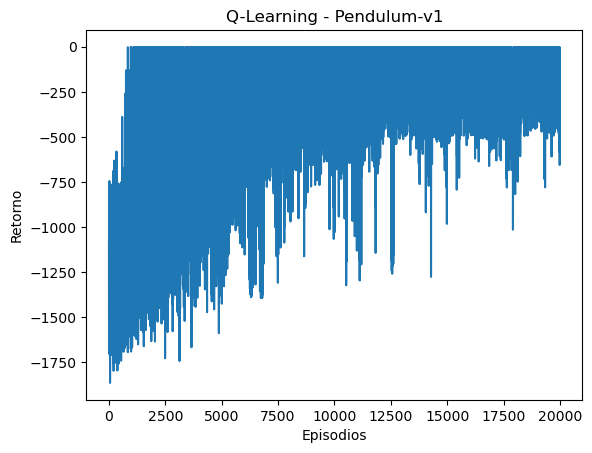

In [23]:
# Guardar gráfico
plt.plot(returns)
plt.xlabel('Episodios')
plt.ylabel('Retorno')
plt.title('Q-Learning - Pendulum-v1')
plt.savefig('resultados/grafico_qlearning.png')
plt.show()

EVALUACIÓN

In [24]:
# Evaluar
media, std = evaluar_politica(policy_det)
print(f"\nEvaluación política final: Retorno medio = {media:.2f}, Std = {std:.2f}")



Evaluación política final: Retorno medio = -189.13, Std = 111.86


VISUALIZACIÓN FINAL

In [25]:
# Visualizar política entrenada
visualizar_politica(policy_det, n_episodios=5)


[EPISODIO 1]
Retorno del episodio 1: -123.11

[EPISODIO 2]
Retorno del episodio 2: -238.96

[EPISODIO 3]
Retorno del episodio 3: -362.72

[EPISODIO 4]
Retorno del episodio 4: -125.78

[EPISODIO 5]
Retorno del episodio 5: -129.45
